In [14]:
import matplotlib.pyplot as plt
import functions
import numpy as np
import math, pyarrow.parquet as pq, os, glob
import pandas as pd

indicators_df = functions.main()
df, odf = functions.read_files("2025-07-12", "2025-07-12")

Введите диапазон дат в формате 01-01-2001 или введите [d] для анализа всех данных
Загрузка данных...
✓ Данные загружены



Выполняется Расчет VPIN:  33%|███▎      | 2/6 [00:00<00:00, 19.27задача/s, ✓ Успешно за 0:00:00.031606]        

Расчет Cummulative Delta выполнена за 0:00:00.040098
Расчет Value Area выполнена за 0:00:00.061739
Расчет Volume Delta выполнена за 0:00:00.031606


Выполняется Расчет Order Flow Imbalance:  67%|██████▋   | 4/6 [00:00<00:00, 17.38задача/s, ✓ Успешно за 0:00:00.088654]

Расчет VPIN выполнена за 0:00:00.088654


Выполняется Расчет Kyle's Lambda: 100%|██████████| 6/6 [00:02<00:00,  2.71задача/s, ✓ Успешно за 0:00:00.029203]       


Расчет Order Flow Imbalance выполнена за 0:00:01.958479
Расчет Kyle's Lambda выполнена за 0:00:00.029203
✓ RF рассчитан

Финальные преобразования данных...
Формирование итоговой таблицы...

✓ Расчет завершен! Результаты:
                     POC_price  POC_volume       VAH       VAL  volume_delta  \
2025-07-12 12:00:00   117482.5      39.543  117556.0  117294.0   -643.446003   
2025-07-12 13:00:00   117200.0      53.551  117405.5  117197.0   -252.908003   
2025-07-12 14:00:00   117555.0      31.369  117685.0  117425.0    -39.292999   
2025-07-12 15:00:00   116988.5      68.040  117264.5  116901.0   -362.718005   
2025-07-12 16:00:00   117300.0      53.992  117350.0  117164.0    -61.466001   
2025-07-12 17:00:00   117400.0      36.915  117519.0  117361.0    203.415000   
2025-07-12 18:00:00   117400.0      67.258  117460.0  117360.0     78.889001   
2025-07-12 19:00:00   117542.0      56.609  117591.5  117478.0     64.314000   
2025-07-12 20:00:00   117289.5      43.656  117420.0  11726

In [15]:
def read_parquet_range(base_dir, subfolder, start_date=None, end_date=None):
    """
    Читает все parquet-файлы из поддиректории (ticks/orderbook) за указанный диапазон дат.
    Если даты не указаны — читает все файлы.
    """
    pattern = os.path.join(
        base_dir, subfolder, "year=*", "month=*", "day=*", "day=*.parquet"
    )
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"No files found in {pattern}")
    
    dfs = []
    for file in files:
        fname = os.path.basename(file)
        date_str = fname.replace("day=", "").replace(".parquet", "")
        if start_date or end_date:
            file_date = pd.to_datetime(date_str)
            if start_date and file_date < pd.to_datetime(start_date):
                continue
            if end_date and file_date > pd.to_datetime(end_date):
                continue
        dfs.append(pd.read_parquet(file))
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        return pd.DataFrame()

In [16]:
def read_files():
    df = read_parquet_range('C:\\Users\\382he\\trading-bot\\data', 'ticks', '2025-07-12', '2025-07-12')
    odf = read_parquet_range('C:\\Users\\382he\\trading-bot\\data', 'orderbook', '2025-07-12', '2025-07-12')
    return df, odf

подсчет сигналов и выбор timestamp

In [17]:
rf = indicators_df['RF']
vpin = indicators_df['VPIN']
ofi = indicators_df['OFI']
kl = indicators_df['Kyle_Lambda']
vol_del = indicators_df['volume_delta']

#условия входов в позиции -- нужно переработать так чтобы он учитывал shift()
buy_rf     = rf <  0.5
sell_rf    = rf >  2.0

buy_vol_del = vol_del > 0
sell_vol_del = vol_del < 0

buy_vpin   = vpin < 0.1
sell_vpin  = vpin > 0.3

buy_ofi    = ofi > 0
sell_ofi   = ofi < 0

buy_kl     = kl <  0.05
sell_kl    = kl >  0.2

open_pos_long = buy_vol_del
close_pos_long = sell_vol_del

open_pos_short = sell_vol_del
close_pos_short = buy_vol_del

#открытие и закрытие позиций
longs_open  = indicators_df.index[ open_pos_long.fillna(False) ].unique()
longs_close = indicators_df.index[ close_pos_long.fillna(False) ].unique()

shorts_open  = indicators_df.index[ open_pos_short.fillna(False) ].unique()
shorts_close = indicators_df.index[ close_pos_short.fillna(False) ].unique()


соотнесение временных меток с ценами и создания списков трейдов

In [18]:
ts = df['recv_time'].astype(np.int64).to_numpy()
pr = df['price'].to_numpy()

# --- Переводим времена в наносекунды для всех сигналов ---
events = {
    'long': {
        'open_idx': longs_open,
        'close_idx': longs_close,
    },
    'short': {
        'open_idx': shorts_open,
        'close_idx': shorts_close,
    }
}

# --- Интерполируем цены для каждого события --- (пиздец медленно)
for direction, ev in events.items():
    ev['open_ns']  = ev['open_idx'].astype(np.int64)
    ev['close_ns'] = ev['close_idx'].astype(np.int64)
    ev['open_pr']  = np.interp(ev['open_ns'],  ts, pr)
    ev['close_pr'] = np.interp(ev['close_ns'], ts, pr)

trades = []
for direction, ev in events.items():
    opens_t, closes_t = ev['open_idx'], ev['close_idx']
    opens_pr, closes_pr  = ev['open_pr'],  ev['close_pr']
    i = j = 0
    while i < len(longs_open) and j < len(longs_close):
        t_o, t_c = opens_t[i], closes_t[j]

        if t_o <= t_c:
            j += 1
            continue

        entry_price = opens_pr[i]
        exit_price  = closes_pr[j]
        profit      = (exit_price - entry_price) if direction == 'long' else (exit_price - entry_price)
        trades.append({
            'direction' : direction,
            'entry_time' : t_o,
            'exit_time'  : t_c,
            'entry_price': entry_price,
            'exit_price' : exit_price,
            'profit'     : profit,
            'return'     : profit / entry_price
        })

    i += 1
    j += 1

KeyboardInterrupt: 

расчет доходности стратегии

In [ ]:
price_ser    = df.set_index('recv_time')['price']
deposit = 10_000
risk = 0.01
equity = [deposit]
times  = [trades[0]['entry_time'] if trades else df['recv_time'].iloc[0]]
for tr in trades:
    ret = (tr['exit_price'] - tr['entry_price']) / tr['entry_price']
    pnl = equity[-1] * risk * ret
    equity.append(equity[-1] + pnl)
    times.append(tr['exit_time'])

# 5) Расчёт buy&hold
bh_price = price_ser
bh_equity = deposit * (bh_price / bh_price.iloc[0])

отрисовка точек входа на цене

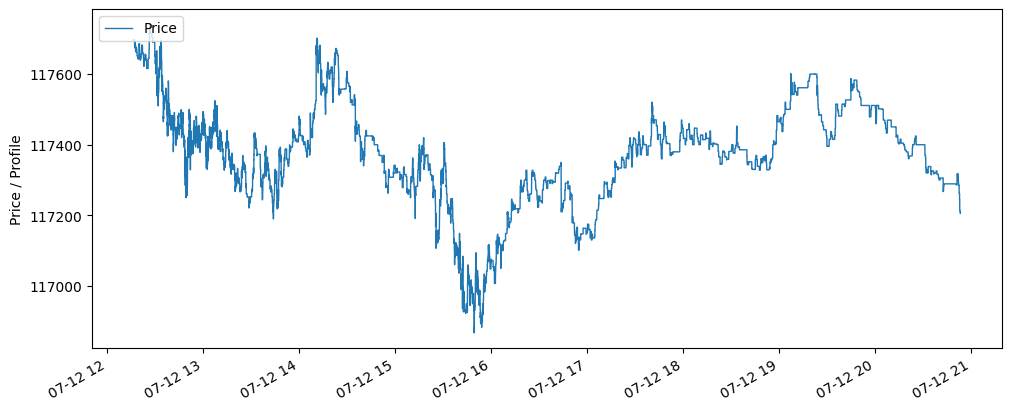

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    figsize=(10, 4),
    constrained_layout=True
)

ax.plot(df['recv_time'], df['price'], label='Price', linewidth=1)

for _ in range(len(trades)):
    ax.scatter(trades[_]['entry_time'],  trades[_]['entry_price'],  marker='^', color='g', s=60, label='Long open')
    ax.scatter(trades[_]['exit_time'], trades[_]['exit_price'], marker='v', color='r', s=60, label='Long close')

ax.set_ylabel("Price / Profile")
ax.legend(loc='upper left')
ax.grid(False)

fig.autofmt_xdate()
plt.show()

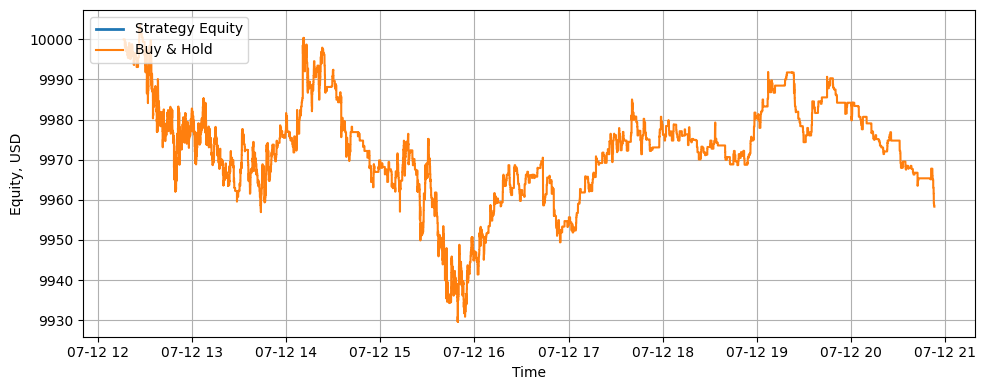

In [ ]:
fig, ax = plt.subplots(
    1, 1,
    figsize = (10, 4)
)

ax.plot(times,       equity,    label='Strategy Equity', linewidth=2)
ax.plot(bh_equity.index, bh_equity.values, label='Buy & Hold')
ax.set_ylabel('Equity, USD')
ax.set_xlabel('Time')
ax.legend(loc='upper left')
ax.grid(True)

plt.tight_layout()
plt.show()